In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal import welch, find_peaks

## Load Files

In [55]:
# DESK
data_desk_classroom = np.load("data_desk_classroom_20251120_170119.npy")
print("data_desk_classroom shape:", data_desk_classroom.shape)

data_desk_davide_relax = np.load("data_desk_davide_relax_20251124_181402.npy")
print("data_desk_davide_relax shape:", data_desk_davide_relax.shape)

data_desk_davide_lettura = np.load("data_desk_davide_lettura_20251124_182213.npy")
print("data_desk_davide_lettura shape:", data_desk_davide_lettura.shape)

data_hand_arr = np.load("data_hand_20251120_165216.npy")
print("Hand Array shape:", data_hand_arr.shape)

data_hand_davide_lettura = np.load("data_hand_davide_lettura_20251124_184702.npy")
print("Hand Array shape:", data_hand_davide_lettura.shape)

data_desk_classroom shape: (350, 65, 65, 2)
data_desk_davide_relax shape: (350, 65, 65, 2)
data_desk_davide_lettura shape: (350, 65, 65, 2)
Hand Array shape: (350, 65, 65, 2)
Hand Array shape: (350, 65, 65, 2)


## Function Definitions

In [56]:
def plot_pixel_change_matrix(data):
    """
    Plot ROI_H x ROI_W heatmaps (one per color channel) where
    darker pixels indicate larger temporal change over frames.

    data: numpy array of shape (num_frames, ROI_H, ROI_W, colors)
    """

    num_frames, ROI_H, ROI_W, colors = data.shape

    # Compute per-pixel temporal variation
    # Here: standard deviation across frames for each pixel & color
    change_map = np.std(data, axis=0)   # shape → (ROI_H, ROI_W, colors)

    # Normalize each color channel independently (0 = highest change → dark)
    norm_change = np.zeros_like(change_map)
    for c in range(colors):
        ch = change_map[:, :, c]
        ch_min, ch_max = ch.min(), ch.max()
        norm_change[:, :, c] = (ch - ch_min) / (ch_max - ch_min + 1e-9)

    # Plot each channel
    fig, axs = plt.subplots(1, colors, figsize=(5 * colors, 5))
    if colors == 1:
        axs = [axs]

    for c in range(colors):
        axs[c].imshow(1 - norm_change[:, :, c], cmap='gray')
        axs[c].set_title(f"Color channel {c}")
        axs[c].axis("off")

    plt.tight_layout()
    plt.show()

In [57]:
def plot_frequency_spectrum(arr, x=32, y=32, channel=0, fs=2.5):
    # Extract the time-series for this pixel
    pixel_ts = arr[:, y, x, channel]

    # Compute Power Spectral Density
    freqs, psd = welch(pixel_ts, fs=fs, nperseg=256)

    # --- Detect peaks ---
    # height: ignore tiny noise peaks by setting a minimum threshold
    # distance: minimum separation between peaks in samples
    peaks, properties = find_peaks(psd, height=np.max(psd)*0.1, distance=3)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, psd, label="PSD")
    plt.scatter(freqs[peaks], psd[peaks], color='red', s=50, label="Peaks")

    # Add labels for each detected peak
    for idx in peaks:
        freq_val = freqs[idx]
        psd_val = psd[idx]
        plt.annotate(f"{freq_val:.2f} Hz",
                     xy=(freq_val, psd_val),
                     xytext=(freq_val, psd_val * 1.1),
                     arrowprops=dict(arrowstyle="->", lw=1))

    plt.title(f"Frequency Spectrum — Pixel ({y},{x}), Channel {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Desk in class

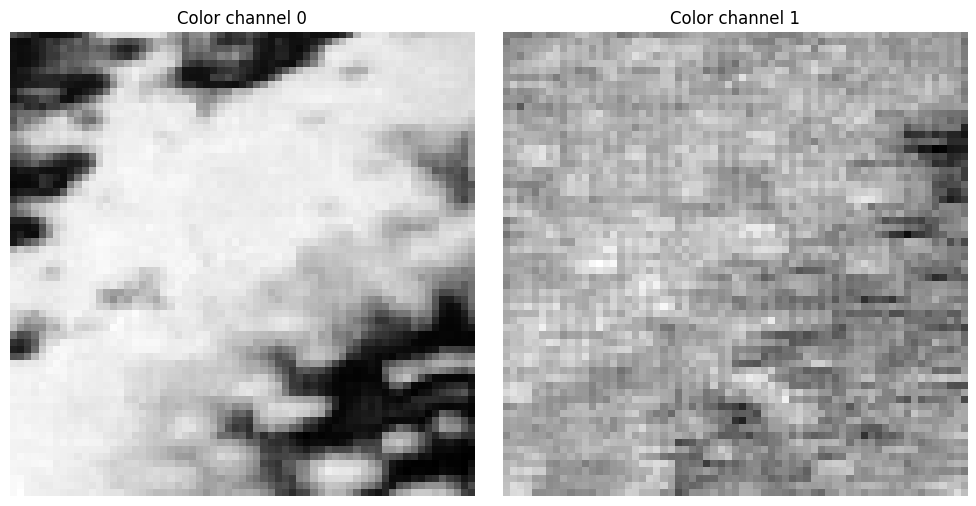

In [58]:
plot_pixel_change_matrix(data=data_desk_classroom)

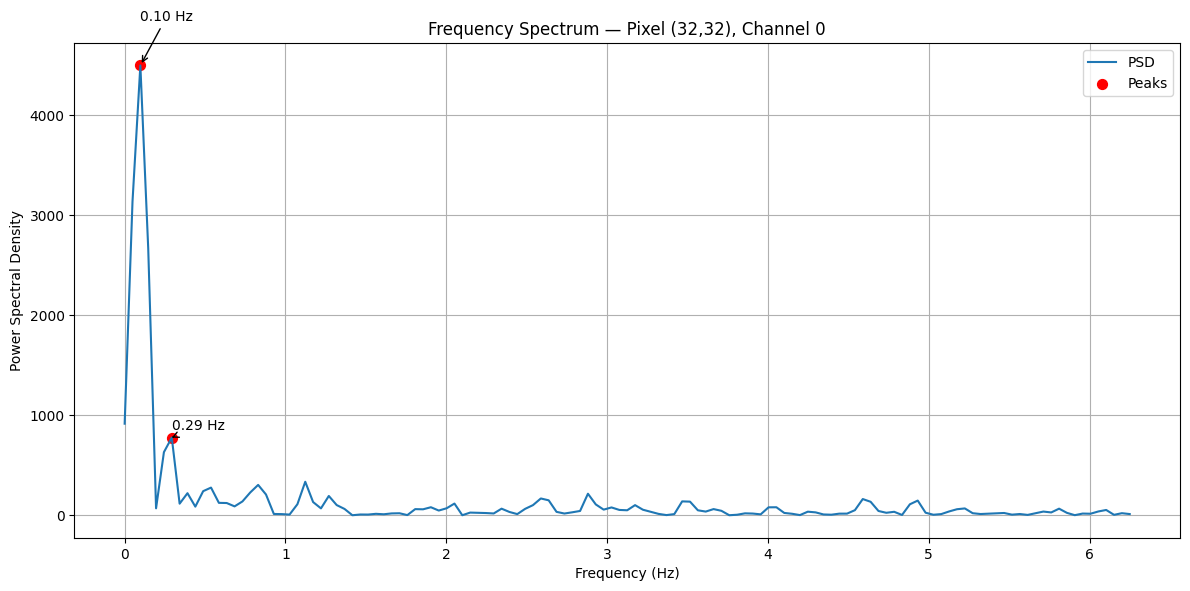

In [59]:
plot_frequency_spectrum(arr=data_desk_classroom, fs=12.5)

## Desk at Davide's Home with 'Relax' color

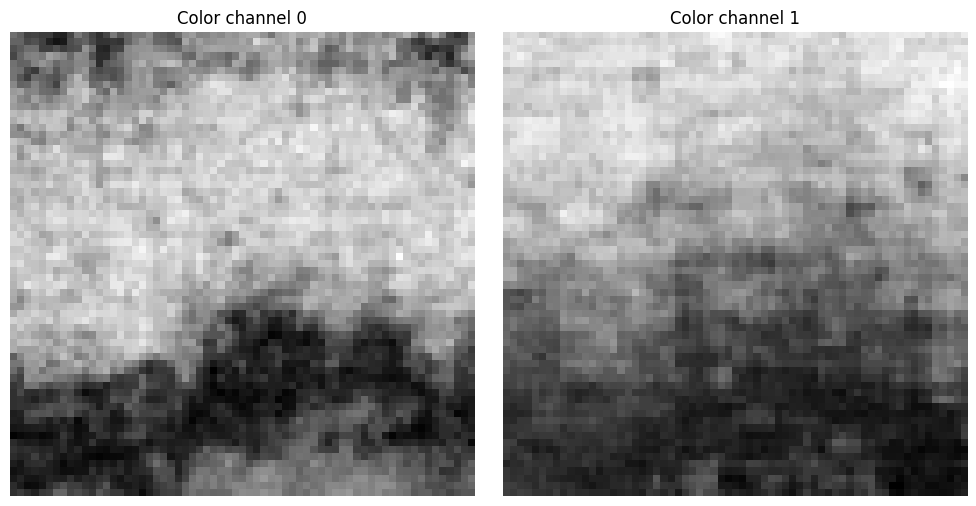

In [60]:
plot_pixel_change_matrix(data=data_desk_davide_relax)

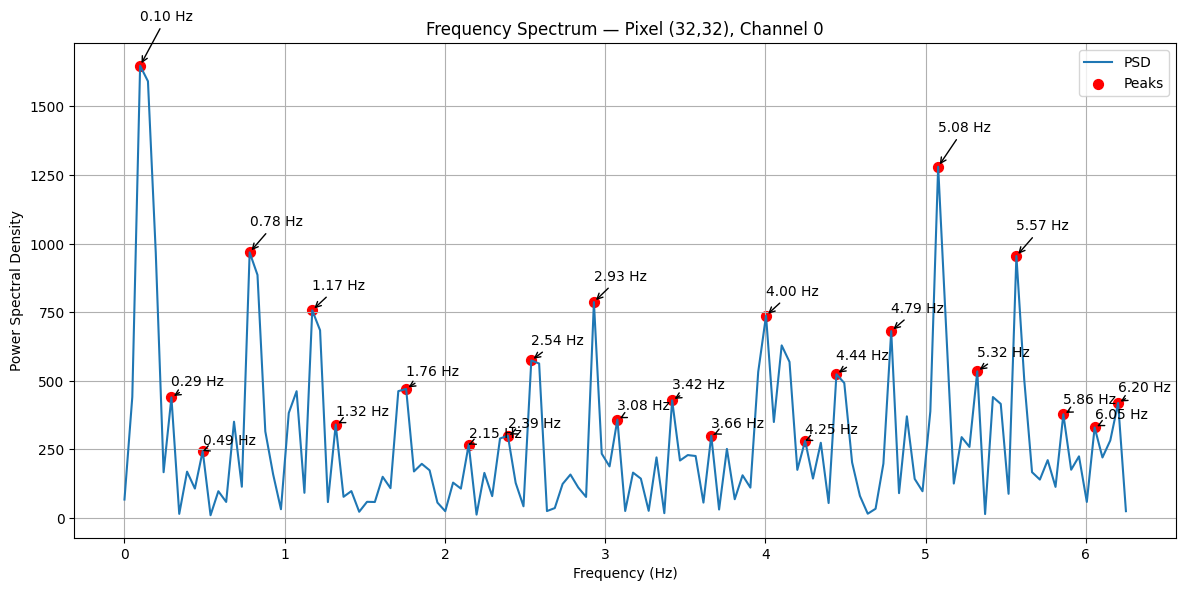

In [61]:
plot_frequency_spectrum(arr=data_desk_davide_relax, fs=12.5)

## Desk at Davide's Home with 'Lettura' color

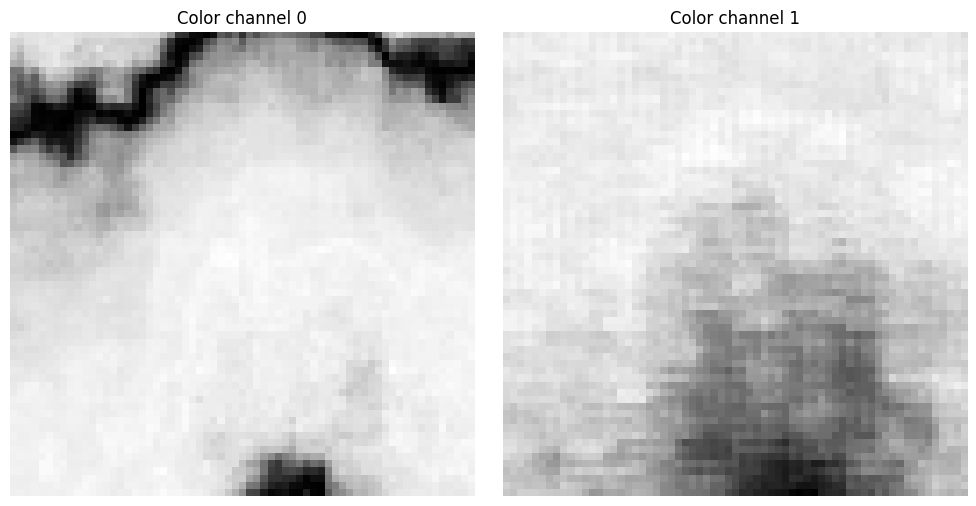

In [62]:
plot_pixel_change_matrix(data=data_desk_davide_lettura)

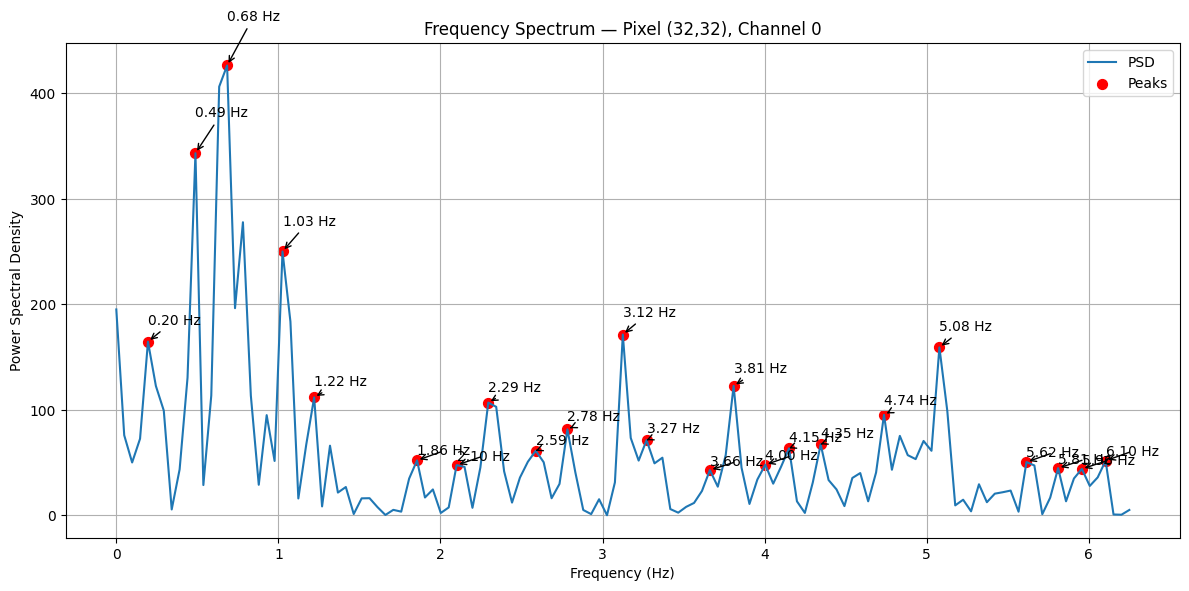

In [63]:
plot_frequency_spectrum(arr=data_desk_davide_lettura, fs=12.5)

## Hand in classroom

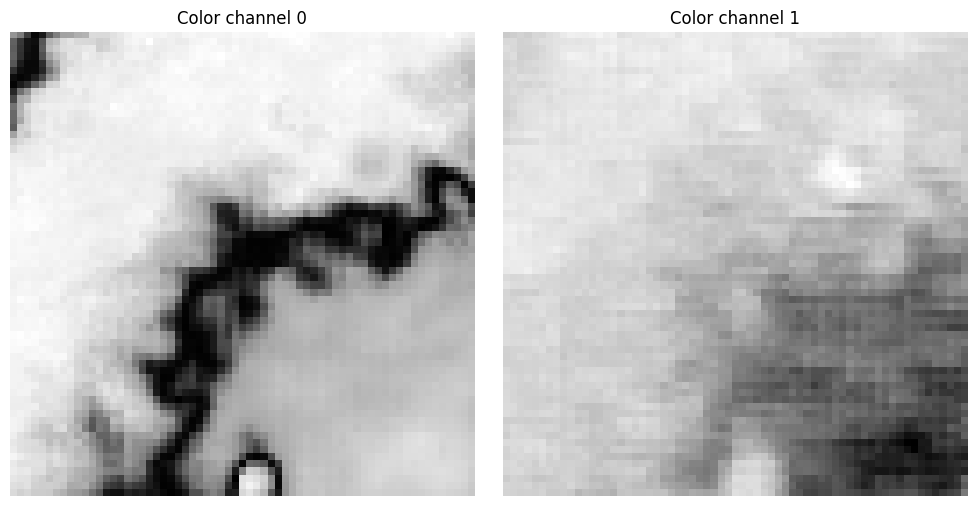

In [64]:
plot_pixel_change_matrix(data=data_hand_arr)

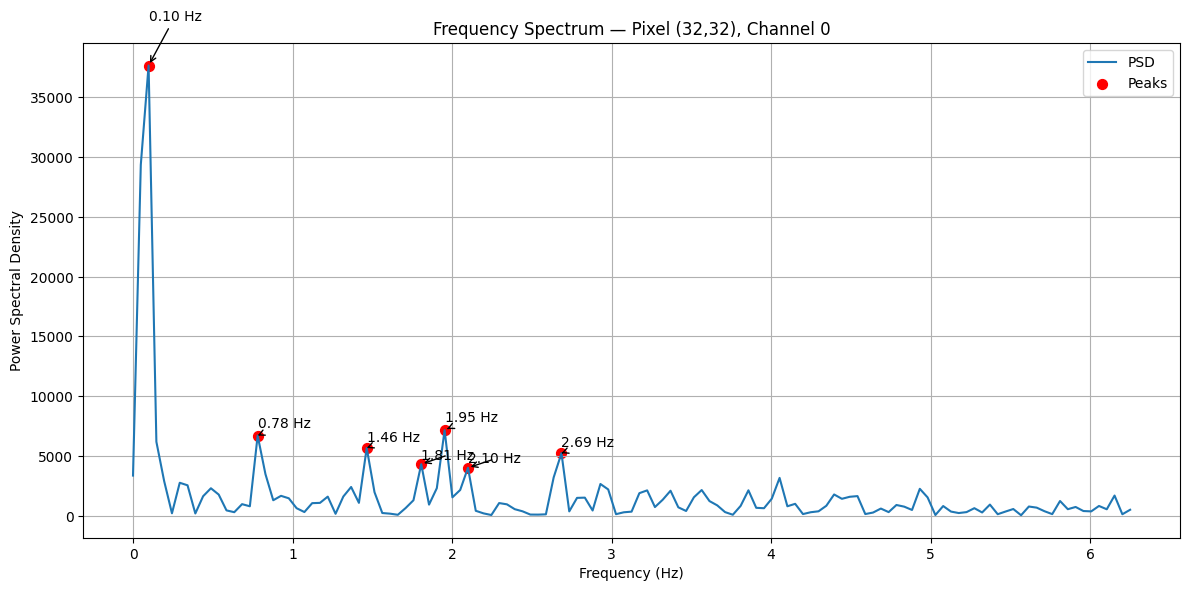

In [65]:
plot_frequency_spectrum(arr=data_hand_arr, fs=12.5)

## Davide's Hand @ Home with 'Lettura' color

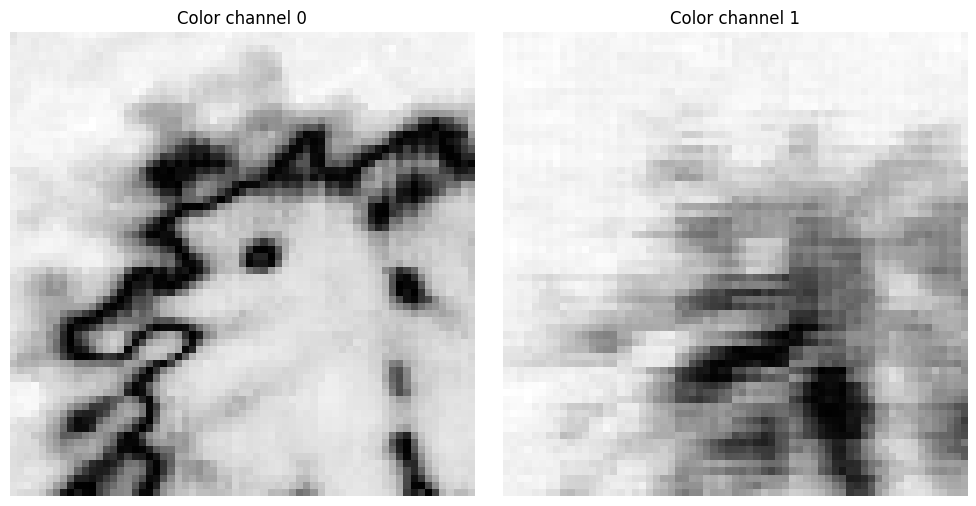

In [66]:
plot_pixel_change_matrix(data=data_hand_davide_lettura)

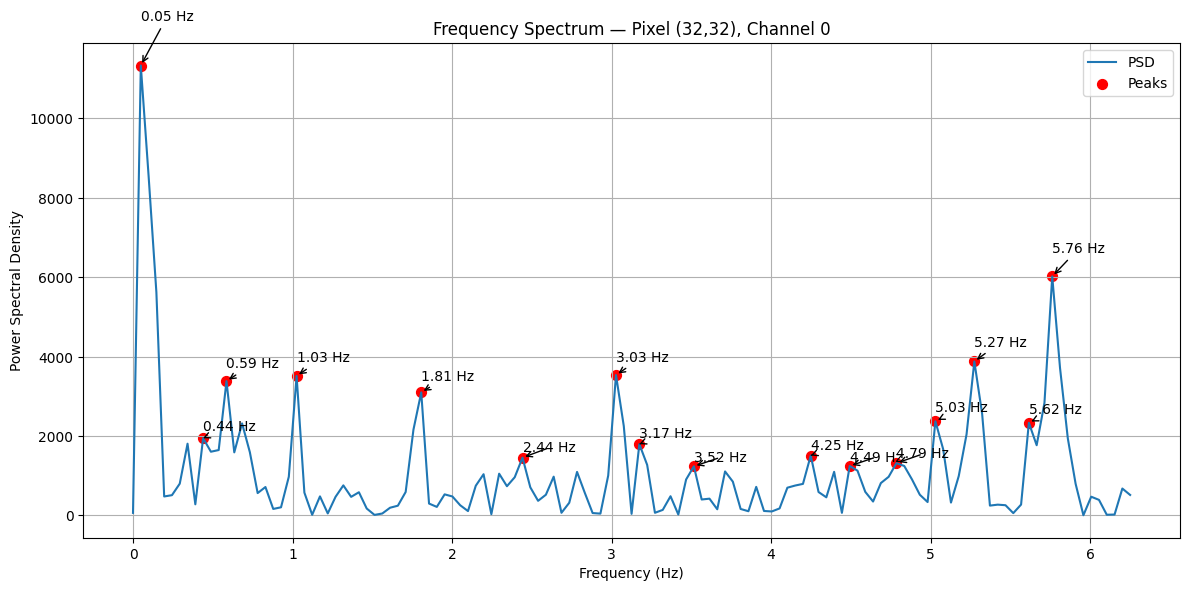

In [67]:
plot_frequency_spectrum(arr=data_hand_davide_lettura, fs=12.5)